## Filtering for CRN with neural martingales

### Chemical Reaction Network setup

In [1]:
import pandas as pd
from CRN_Simulation_Inference.RB_method_for_model_identification.RBForModelIdentification import RBForModelIdentification
import numpy as np
import matplotlib.pyplot as plt  
from tqdm import tqdm
import torch

species_names = ['G0', 'G1', 'mRNA']
stoichiometric_matrix = [[-1, 1, 0, 0],
                         [1, -1, 0, 0],
                         [0, 0, 1,-1]]
parameters_names = ['k1','k2', 'kp1']
reaction_names = ['G Act. 1', 'G Deg. 1', 'mRNA prod.', 'mRNA deg.']
propensities = [
    lambda k1, G0: k1*G0,
    lambda k2, G1: k2*G1,
    lambda kp1, G1: kp1*G1,
    lambda mRNA: mRNA
]

range_of_species = \
    pd.DataFrame([[0, 1], [0, 1], [0, 120] ], index=species_names, columns=['min', 'max'])
range_of_parameters= \
    pd.DataFrame([[0, 1], [0, 1], [0, 150]],index=parameters_names,columns=['min', 'max'])
discretization_size_parameters = \
    pd.DataFrame([21, 21, 151], index=parameters_names) #index=parameters_names

# The observation related information
# h_function = [
#     lambda Protein: Protein
# ]
h_function = [
    lambda mRNA: np.where(mRNA > 7, mRNA, 0)
]
observation_noise_intensity = [
    lambda : 1
]
#observation_noise_intensity = {'sigma1': 0.1}

maximum_size_of_each_follower_subsystem = 20000 #800 # 1000


MI = RBForModelIdentification(
    species_names=species_names,
    stoichiometric_matrix=stoichiometric_matrix,
    parameters_names=parameters_names,
    reaction_names=reaction_names,
    propensities=propensities,
    range_of_species=range_of_species,
    range_of_parameters=range_of_parameters,
    observation_noise_intensity=observation_noise_intensity,
    discretization_size_parameters=discretization_size_parameters,
    h_function=h_function,
    maximum_size_of_each_follower_subsystem=maximum_size_of_each_follower_subsystem)

print('leader species: ', MI.leader_species_time_course_data)
print('follower species: ', MI.get_follower_species_time_course_data())
print('follower parameters: ', MI.get_follower_parameters_time_course_data())

leader species:  ['G1']
follower species:  ['mRNA', 'G0']
follower parameters:  ['kp1', 'k1', 'k2']


setup parameters and simulate

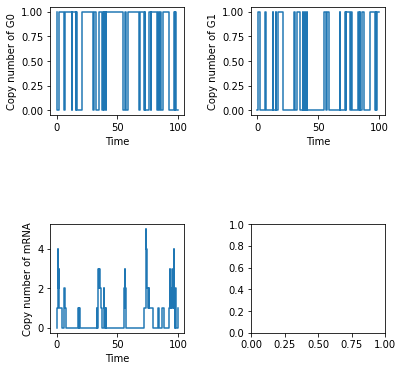

In [2]:
# Get a trajectory of the system
parameter_values_sets = []
parameter_values_sets.append({'k1': 0.3, 'k2': 0.4, 'kp1': 1}) # base parameters
parameter_values_sets.append({'k1': 0.3, 'k2': 0.8, 'kp1': 2})

parameter_set_index = 1
parameter_values = parameter_values_sets[parameter_set_index]
initial_state = {'G0': 1, 'G1': 0, 'mRNA': 0}
tf = 100
time_list, state_list, cPP = MI.SSA(initial_state, parameter_values, 0, tf, compute_centered_poisson_process=True)
MI.plot_trajectories(time_list, state_list)

# Generate the observations
dt = 1.
Observation_times_list = np.arange(dt, tf+dt, dt)
Y_list = MI.generate_observations(state_list, time_list, parameter_values, Observation_times_list)

visualize the centered Poisson Process

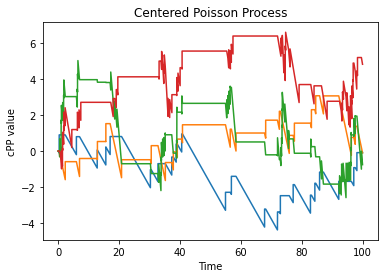

In [3]:
cPP.plot() 

For simplicity, we provide an helper function to prepare X, Y and the cPP through SSA simulations

In [4]:
# helper functions for defining the sampling times for the X and Y processes

def count_samples_for_supersampling(original, intensity):
    """ 
    Prepare supersampling for X ranges
    """
    x = original
    n_holes = x - 1
    x = intensity * n_holes + x
    return x

def get_X_Y_sampling_times(t0, tn, number_of_Y_samples, X_supersampling_intensity):
    """ 
    helper function to get sampling times for the X and Y processes
    """
    assert number_of_Y_samples % 2 == 1 and number_of_Y_samples > 1, "the number of mesurements must be odd and greater than 1 to include the extremes"
    assert X_supersampling_intensity > 0, "we require some supersampling on the X"
    forY = np.linspace(t0, tn, number_of_Y_samples)
    forX = np.linspace(t0, tn, count_samples_for_supersampling(number_of_Y_samples, X_supersampling_intensity))
    return forX, forY

def sample_trajectory_on_times(sampling_points, time_list, state_list):
    """ 
    sample a trajectory on specific time points
    """

    sampling_time_index = 0
    real_time_index = 0

    sampled_state_list = []

    while sampling_time_index < len(sampling_points):
        if real_time_index == len(time_list):
            sampled_state_list.append(state_list[real_time_index-1].copy())
            sampling_time_index += 1
        elif time_list[real_time_index] < sampling_points[sampling_time_index]:
            real_time_index += 1
        else:
            sampled_state_list.append(state_list[real_time_index-1].copy())
            sampling_time_index += 1

    return sampled_state_list


def CRN_simulations_to_dataloaders(data, batch_size, test_split=0.2, shuffle_dataset=True):
    """ 
    convert a dataset to a batched torch dataset
    """

    # torchify
    tX = torch.tensor(data["times_X"])
    tY = torch.tensor(data["times_Y"])
    Xs = torch.stack([torch.tensor(np.array(X)) for X in data["X"]])
    Ys = torch.stack([torch.tensor(np.array(Y)) for Y in data["Y"]])
    Rs = torch.stack([torch.tensor(np.array(R)) for R in data["R"]])

    dataset = torch.utils.data.TensorDataset(Xs, Ys, Rs)
    train_set, test_set = torch.utils.data.random_split(dataset, [int(len(dataset)*(1-test_split)), int(len(dataset)*test_split)])

    train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=shuffle_dataset)
    test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, tX, tY


def run_SSA_for_filtering(MI, initial_state, parameter_values, t_fin, number_of_Y_samples, X_supersampling_intensity, t0=0, n_samples=1):
    """ 
    run multiple SSA simulations with the specified sampling strategy
    """

    X_sampling_times, Y_sampling_times = get_X_Y_sampling_times(t0, t_fin, number_of_Y_samples, X_supersampling_intensity)

    state_lists = []
    R_lists = []
    Y_lists = []

    for _ in tqdm(range(n_samples)):

        time_list, state_list, cPP = MI.SSA(initial_state, parameter_values, t0, t_fin, compute_centered_poisson_process=True)
        
        sampled_state_list = sample_trajectory_on_times(X_sampling_times, time_list, state_list)
        state_lists.append(sampled_state_list)
        # TODO check if R+ and R- are needed
        R = cPP.sample_at_times(X_sampling_times)
        R_lists.append(R)

        # Generate the observations
        Observation_times_list = Y_sampling_times
        Y_list = MI.generate_observations(state_list, time_list, parameter_values, Observation_times_list)
        Y_lists.append(Y_list)

    data = {"times_X" : X_sampling_times, "times_Y" : Y_sampling_times, "X" : state_lists, "Y" : Y_lists, "R" : R_lists}

    return data

### Debugging information

In [5]:
cPP.time_list

[0.0,
 0.3378390198406443,
 0.4987875189383607,
 0.9590745192964476,
 0.9787951578729651,
 1.0673150956925002,
 1.1231188687223503,
 1.4073082893318243,
 1.4661908944666817,
 1.4896540679437693,
 1.7905523664534486,
 1.8028368766384368,
 1.862073061328271,
 1.895756259489699,
 2.2709370031796583,
 2.3252252888743445,
 4.48506577744876,
 5.988130415207652,
 6.278418273205506,
 6.317990859144759,
 6.362038065447953,
 6.487037554449842,
 6.858254209262711,
 7.0173994918517115,
 7.437654716852816,
 12.825905804096234,
 12.896707815263007,
 15.657685499523426,
 15.666018983608476,
 17.069941352113336,
 17.278461014416063,
 18.069011600085336,
 18.58551261530991,
 19.087696483509664,
 19.311050377824188,
 19.60200140754356,
 20.82584786323143,
 30.302029006111137,
 30.575284279963228,
 32.79195048188355,
 33.03437249925926,
 33.15869951241919,
 33.76519266156584,
 33.83587698786025,
 33.92672852232005,
 33.99779825542972,
 34.33105782705192,
 34.70212124547245,
 34.79017714652178,
 34.869681

In [6]:
cPP.current_a

[array([0.3, 0. , 0. , 0. ]),
 array([0.3, 0. , 0. , 0. ]),
 array([0. , 0.8, 2. , 0. ]),
 array([0. , 0.8, 2. , 1. ]),
 array([0. , 0.8, 2. , 2. ]),
 array([0. , 0.8, 2. , 3. ]),
 array([0. , 0.8, 2. , 4. ]),
 array([0. , 0.8, 2. , 3. ]),
 array([0. , 0.8, 2. , 2. ]),
 array([0. , 0.8, 2. , 1. ]),
 array([0. , 0.8, 2. , 2. ]),
 array([0. , 0.8, 2. , 3. ]),
 array([0. , 0.8, 2. , 2. ]),
 array([0. , 0.8, 2. , 3. ]),
 array([0. , 0.8, 2. , 2. ]),
 array([0. , 0.8, 2. , 1. ]),
 array([0.3, 0. , 0. , 1. ]),
 array([0.3, 0. , 0. , 0. ]),
 array([0. , 0.8, 2. , 0. ]),
 array([0. , 0.8, 2. , 1. ]),
 array([0. , 0.8, 2. , 0. ]),
 array([0. , 0.8, 2. , 1. ]),
 array([0. , 0.8, 2. , 2. ]),
 array([0. , 0.8, 2. , 1. ]),
 array([0.3, 0. , 0. , 1. ]),
 array([0.3, 0. , 0. , 0. ]),
 array([0. , 0.8, 2. , 0. ]),
 array([0.3, 0. , 0. , 0. ]),
 array([0. , 0.8, 2. , 0. ]),
 array([0.3, 0. , 0. , 0. ]),
 array([0. , 0.8, 2. , 0. ]),
 array([0. , 0.8, 2. , 1. ]),
 array([0. , 0.8, 2. , 0. ]),
 array([0.

In [7]:
cPP.centered_PP_mean

[array([0., 0., 0., 0.]),
 array([0.10135171, 0.        , 0.        , 0.        ]),
 array([0.10135171, 0.1287588 , 0.321897  , 0.        ]),
 array([0.10135171, 0.4969884 , 1.242471  , 0.460287  ]),
 array([0.10135171, 0.51276491, 1.28191228, 0.49972828]),
 array([0.10135171, 0.58358086, 1.45895215, 0.76528809]),
 array([0.10135171, 0.62822388, 1.5705597 , 0.98850318]),
 array([0.10135171, 0.85557542, 2.13893854, 1.84107144]),
 array([0.10135171, 0.9026815 , 2.25670375, 1.95883666]),
 array([0.10135171, 0.92145204, 2.3036301 , 1.98229983]),
 array([0.10135171, 1.16217068, 2.90542669, 2.58409643]),
 array([0.10135171, 1.17199829, 2.92999571, 2.62094996]),
 array([0.10135171, 1.21938723, 3.04846808, 2.73942233]),
 array([0.10135171, 1.24633379, 3.11583448, 2.84047192]),
 array([0.10135171, 1.54647839, 3.86619597, 3.59083341]),
 array([0.10135171, 1.58990902, 3.97477254, 3.64512169]),
 array([0.74930385, 1.58990902, 3.97477254, 5.80496218]),
 array([1.20022324, 1.58990902, 3.97477254, 5.

In [8]:
cPP.centered_PP

[array([0., 0., 0., 0.]),
 array([0.89864829, 0.        , 0.        , 0.        ]),
 array([ 0.89864829, -0.1287588 ,  0.678103  ,  0.        ]),
 array([ 0.89864829, -0.4969884 ,  0.757529  , -0.460287  ]),
 array([ 0.89864829, -0.51276491,  1.71808772, -0.49972828]),
 array([ 0.89864829, -0.58358086,  2.54104785, -0.76528809]),
 array([ 0.89864829, -0.62822388,  2.4294403 ,  0.01149682]),
 array([ 0.89864829, -0.85557542,  1.86106146,  0.15892856]),
 array([ 0.89864829, -0.9026815 ,  1.74329625,  1.04116334]),
 array([ 0.89864829, -0.92145204,  2.6963699 ,  1.01770017]),
 array([ 0.89864829, -1.16217068,  3.09457331,  0.41590357]),
 array([ 0.89864829, -1.17199829,  3.07000429,  1.37905004]),
 array([ 0.89864829, -1.21938723,  3.95153192,  1.26057767]),
 array([ 0.89864829, -1.24633379,  3.88416552,  2.15952808]),
 array([ 0.89864829, -1.54647839,  3.13380403,  2.40916659]),
 array([ 0.89864829, -0.58990902,  3.02522746,  2.35487831]),
 array([ 0.25069615, -0.58990902,  3.02522746,  

In [9]:
cPP.sample_at_times([9.99, 10., 10.01])

array([[-0.0920034 , -0.41332428,  3.96668931,  2.70863193],
       [-0.0950034 , -0.41332428,  3.96668931,  2.70863193],
       [-0.0980034 , -0.41332428,  3.96668931,  2.70863193]])

In [10]:
print(cPP.at(9.99))
print(cPP.at(10.01))

[-0.0920034  -0.41332428  3.96668931  0.15628664]
[-0.0980034  -0.41332428  3.96668931  0.13628664]


In [11]:
cPP.centered_PP_actual

[array([0., 0., 0., 0.]),
 array([1., 0., 0., 0.]),
 array([1., 0., 1., 0.]),
 array([1., 0., 2., 0.]),
 array([1., 0., 3., 0.]),
 array([1., 0., 4., 0.]),
 array([1., 0., 4., 1.]),
 array([1., 0., 4., 2.]),
 array([1., 0., 4., 3.]),
 array([1., 0., 5., 3.]),
 array([1., 0., 6., 3.]),
 array([1., 0., 6., 4.]),
 array([1., 0., 7., 4.]),
 array([1., 0., 7., 5.]),
 array([1., 0., 7., 6.]),
 array([1., 1., 7., 6.]),
 array([1., 1., 7., 7.]),
 array([2., 1., 7., 7.]),
 array([2., 1., 8., 7.]),
 array([2., 1., 8., 8.]),
 array([2., 1., 9., 8.]),
 array([ 2.,  1., 10.,  8.]),
 array([ 2.,  1., 10.,  9.]),
 array([ 2.,  2., 10.,  9.]),
 array([ 2.,  2., 10., 10.]),
 array([ 3.,  2., 10., 10.]),
 array([ 3.,  3., 10., 10.]),
 array([ 4.,  3., 10., 10.]),
 array([ 4.,  4., 10., 10.]),
 array([ 5.,  4., 10., 10.]),
 array([ 5.,  4., 11., 10.]),
 array([ 5.,  4., 11., 11.]),
 array([ 5.,  4., 12., 11.]),
 array([ 5.,  4., 12., 12.]),
 array([ 5.,  4., 13., 12.]),
 array([ 5.,  4., 13., 13.]),
 arr

In [12]:
len(cPP.time_list)

148

In [13]:
np.searchsorted(np.array(cPP.time_list), 0.01, side='right') - 1

0

In [14]:
cPP.time_list

[0.0,
 0.3378390198406443,
 0.4987875189383607,
 0.9590745192964476,
 0.9787951578729651,
 1.0673150956925002,
 1.1231188687223503,
 1.4073082893318243,
 1.4661908944666817,
 1.4896540679437693,
 1.7905523664534486,
 1.8028368766384368,
 1.862073061328271,
 1.895756259489699,
 2.2709370031796583,
 2.3252252888743445,
 4.48506577744876,
 5.988130415207652,
 6.278418273205506,
 6.317990859144759,
 6.362038065447953,
 6.487037554449842,
 6.858254209262711,
 7.0173994918517115,
 7.437654716852816,
 12.825905804096234,
 12.896707815263007,
 15.657685499523426,
 15.666018983608476,
 17.069941352113336,
 17.278461014416063,
 18.069011600085336,
 18.58551261530991,
 19.087696483509664,
 19.311050377824188,
 19.60200140754356,
 20.82584786323143,
 30.302029006111137,
 30.575284279963228,
 32.79195048188355,
 33.03437249925926,
 33.15869951241919,
 33.76519266156584,
 33.83587698786025,
 33.92672852232005,
 33.99779825542972,
 34.33105782705192,
 34.70212124547245,
 34.79017714652178,
 34.869681

In [15]:
cPP.centered_PP

[array([0., 0., 0., 0.]),
 array([0.89864829, 0.        , 0.        , 0.        ]),
 array([ 0.89864829, -0.1287588 ,  0.678103  ,  0.        ]),
 array([ 0.89864829, -0.4969884 ,  0.757529  , -0.460287  ]),
 array([ 0.89864829, -0.51276491,  1.71808772, -0.49972828]),
 array([ 0.89864829, -0.58358086,  2.54104785, -0.76528809]),
 array([ 0.89864829, -0.62822388,  2.4294403 ,  0.01149682]),
 array([ 0.89864829, -0.85557542,  1.86106146,  0.15892856]),
 array([ 0.89864829, -0.9026815 ,  1.74329625,  1.04116334]),
 array([ 0.89864829, -0.92145204,  2.6963699 ,  1.01770017]),
 array([ 0.89864829, -1.16217068,  3.09457331,  0.41590357]),
 array([ 0.89864829, -1.17199829,  3.07000429,  1.37905004]),
 array([ 0.89864829, -1.21938723,  3.95153192,  1.26057767]),
 array([ 0.89864829, -1.24633379,  3.88416552,  2.15952808]),
 array([ 0.89864829, -1.54647839,  3.13380403,  2.40916659]),
 array([ 0.89864829, -0.58990902,  3.02522746,  2.35487831]),
 array([ 0.25069615, -0.58990902,  3.02522746,  

In [16]:
cPP.sample_at_times([9.99, 10.01])

array([[-0.0920034 , -0.41332428,  3.96668931,  2.70863193],
       [-0.0980034 , -0.41332428,  3.96668931,  2.70863193]])

In [17]:
cPP.at(9.99)

array([-0.0920034 , -0.41332428,  3.96668931,  0.15628664])

In [18]:
np.searchsorted(np.array(cPP.time_list), 9.99, side='right') - 1

24

### Dataloader structure

Let $\mathcal{T}$ be the set of measurement times, $\Tau$ the time discretization set, and $\mathcal{R}$ be the set of reactions. The dataloader should contain:

* $X(t) \forall t\in\Tau$ the full process 
* $Y(t) \forall t\in\mathcal{T}$ the observed process
* $\tilde{R}_k(t) \forall t\in\Tau, k\in \mathcal{R}$ the centered poisson process associated to the reaction $k$ 

this implies the following tensor dimensions (we condiser the batch size $B$) of the input tensors, respectively:

* $[B, |\Tau|, |X|]$
* $[B, |\mathcal{T}|, |y|]$
* $[B, |\Tau|, |r|]$


In [19]:
# this can be done quickly by running 

n_samples = 100
batch_size = 10

dataset = run_SSA_for_filtering(MI, initial_state, parameter_values, tf, 11, 1, n_samples=n_samples)
train_dataset, val_dataset, Xtimes, Ytimes = CRN_simulations_to_dataloaders(dataset, batch_size)

[ x.shape for x in next(iter(train_dataset))]

100%|██████████| 100/100 [00:01<00:00, 69.96it/s]


[torch.Size([10, 21, 3]), torch.Size([10, 11, 1]), torch.Size([10, 21, 4])]

#### TODO list

* prepare likelihood computatons
* consider slicing mechanism, and timepoint slicing and converions
* for cPP, verify when needed, and apply more strict sampling frequency
* implement a simple NN for the loss function
* mmmmmmmmmm


### Neural Network setup

We omit the definition of the CRN, which is done at the beginning of the file

In [25]:
from ElenaNetworks import MLP, RNNEncoder, NeuralMartingale

Delta = torch.tensor(MI.stoichiometric_matrix)

# we need a version of the h_function that is efficient for torch computations (maybe?)

XEncoder = MLP(MI.get_number_of_species(), 16, 16, 3)
YEncoder = RNNEncoder(len(h_function), 16)
backbone = MLP(1+XEncoder.output_size+YEncoder.embedding_size, 16, 1, 2)

NN = NeuralMartingale(XEncoder, YEncoder, backbone)
NN

NeuralMartingale(
  (X_encoder): MLP(
    (layers): Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): Tanh()
      (2): Sequential(
        (0): Linear(in_features=16, out_features=16, bias=True)
        (1): Tanh()
      )
      (3): Sequential(
        (0): Linear(in_features=16, out_features=16, bias=True)
        (1): Tanh()
      )
      (4): Linear(in_features=16, out_features=16, bias=True)
    )
  )
  (Y_encoder): RNNEncoder(
    (RNN): LSTM(1, 16, batch_first=True)
  )
  (backbone): MLP(
    (layers): Sequential(
      (0): Linear(in_features=33, out_features=16, bias=True)
      (1): Tanh()
      (2): Sequential(
        (0): Linear(in_features=16, out_features=16, bias=True)
        (1): Tanh()
      )
      (3): Linear(in_features=16, out_features=1, bias=True)
    )
  )
)

### Training loop

now we have to define the training loop

In [ ]:
def likelihood(Y, X, h_transform, noise_covariance):
    hx = h_transform(X)
    return torch.nn.functional.gaussian_nll_loss(Y, hx, noise_covariance, full=True, reduction='none')

def G(model, t, Xslice, Yslice):
        return likelihood(Xslice, Yslice[:, -1, :], model.h_transform, model.noise_covariance)*model(t,Xslice,Yslice)



def MartingaleLoss(model, X, Y, R..):
    # time is at the second dimension (batch, time, components)
    base_case_G = likelihood(Y[:, -1, :], X[:, -1, :], model.h_transform, model.noise_covariance)*model.g_function(X[:, -1, :])


    
    
    
    

